# Keras를 사용한 ML(머신러닝) 기본사항
## 3. 사전 처리된 텍스트로 텍스트 분류
### - 영화 리뷰를 사용한 텍스트 분류
#### 참고사이트 : https://www.tensorflow.org/tutorials/keras/text_classification?hl=ko

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


In [3]:
# IMDB 데이터셋 다운로드
imdb = keras.datasets.imdb

# num_words는 훈련 데이터에서 가장 많이 등장하는 상위 10,000개의 단어 선택
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


In [6]:
# 데이터셋의 샘플은 전처리된 정수 배열로 label은 0(부정) 또는 1(긍정)
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))
print("테스트 샘플: {}, 레이블: {}".format(len(test_data), len(test_labels)))

훈련 샘플: 25000, 레이블: 25000
테스트 샘플: 25000, 레이블: 25000


In [8]:
# 리뷰 텍스트는 vocabulary의 특정 단어를 나타내는 정수로 변환된 1차원 배열
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [11]:
# 그렇기 때문에 당연히 영화 리뷰들은 길이가 다름
# But! 신경망의 입력은 길이가 같아야함!(밑에서 해결)
len(train_data[0]), len(train_data[1]), len(train_data[2]), len(train_data[3]), len(train_data[4])

(218, 189, 141, 550, 147)

In [12]:
# 정수를 단어로 다시 변환하기

# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [15]:
# decode_review 함수를 사용해 첫번째 리뷰 텍스트 출력
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [16]:
# 데이터 준비
# 리뷰(정수배열)은 신경망에 주입하기 전에 텐서로 변환되어야 함.
# 텐서 변환을 위해 one-hot encoding과 정수 배열의 길이가 모두 같도록 max_length만큰 패딩을 추가하는 등의 방법이 있음.
# 이 예제에서는 2번째 방법을 사용(pad_sequences 함수를 사용해 길이 일치화 작업)
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [21]:
# 위에서 모두 다르던 리뷰데이터 배열의 길이가 모두 같아짐
# 생성된 텐서는 신경망의 첫번째 층으로 사용
len(train_data[0]), len(train_data[1]), len(train_data[2]), len(train_data[3]), len(train_data[4])

(256, 256, 256, 256, 256)

In [23]:
# 원래 218 크기의 배열이 패딩(0 추가) 작업을 통해 256 길이가 됨
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [25]:
# 모델구성
# 신경망은 층(layer)을 쌓아서 만들어짐
# 결정사항은 2가지 = 얼마나 많은 layer를 사용할지? 얼마나 많은 hidden unit을 사용할지?

# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다(10,000개의 단어)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# 아래 출력값을 보면 층을 순서대로 쌓아 classifier(분류기)를 생성
# 1. Embedding층 = 정수로 인코딩된 단어를 입력받고 , 각 단어 인덱스에 해당하는 embedding vector를 찾음
#                  이 벡터는 모델이 훈련되면서 학습되며 최종적으로 (batch, sequence, embedding) 차원이 됨.
# 2. GlobalAveragePolling1D층 = sequence 차원의 평균을 계산하여 각 샘플링에 대해 고정된 길이의 출력 벡터 반환(길이 다른 입력을 다루는 가장 easy한 방법)
# 3. Dense2 = 16개의 hidden unit(은닉유닛)을 가진 fully-connected dense를 거침(relu는 음수를 0으로 만드는 함수)
# 4. Dense3 = 하나의 출력 노드를 가진 완전연결층(sigmoid 함수를 사용해 0~1 사이의 실수를 출력하며, 이 값은 확률 또는 신뢰도를 의미)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 위에서 생성한 모델이 훈련(학습)하려면 손실함수(loss function)와 옵티마이저(optimizer)가 필요
# 이 모델은 이진분류 문제이며 확률을 출력하므로 binary_crosentropy 손실함수를 사용
# binary_crossentropy 손실 함수는 확률을 다루는데 적합하며 확률 분포 간의 거리를 측정(정답~예측 사이의 거리)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
# 검증 세트 만들기
# 모델이 훈련할 때 본 적 없는 데이터에서 정확도를 확인 하는 것이 좋음
# 원본 훈련 데이터 25000개 중 10000개의 샘플을 떼어 validation set을 생성

x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [54]:
# 모델 훈련(학습)
# 512개의 샘플로 이루어진 미니배치에서 40번의 epoch 동안 훈련(x_train과 y_train 텐서에 있는 모든 샘플에 대해 40번 반복)
# 훈련하는 동안 10000개의 검증세트에서 모델의 손실도와 정확도 모니터링(loss는 점점 줄고, accuracy는 점점 증가)
# verbose 옵션은 학습의 진행상황을 보여줄지 말지(0이면 안보여줌, 1이면 보여줌)
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 0s 23us/sample - loss: 0.0214 - accuracy: 0.9979 - val_loss: 0.4936 - val_accuracy: 0.8677
Epoch 2/40
15000/15000 [==============================] - 0s 24us/sample - loss: 0.0205 - accuracy: 0.9982 - val_loss: 0.5006 - val_accuracy: 0.8677
Epoch 3/40
15000/15000 [==============================] - 0s 23us/sample - loss: 0.0198 - accuracy: 0.9982 - val_loss: 0.5055 - val_accuracy: 0.8680
Epoch 4/40
15000/15000 [==============================] - 0s 24us/sample - loss: 0.0191 - accuracy: 0.9984 - val_loss: 0.5111 - val_accuracy: 0.8676
Epoch 5/40
15000/15000 [==============================] - 0s 22us/sample - loss: 0.0184 - accuracy: 0.9985 - val_loss: 0.5162 - val_accuracy: 0.8672
Epoch 6/40
15000/15000 [==============================] - 0s 23us/sample - loss: 0.0177 - accuracy: 0.9985 - val_loss: 0.5213 - val_accuracy: 0.8668
Epoch 7/40
15000/15000 [==============================] 

In [55]:
# 모델 평가
# 모델의 성능을 확인하기 위해 손실(loss)과 정확도(accuracy) 출력
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results) # 정확도 85% 달성(고급 방법을 사용하면 95% 이상으로 올라감)

25000/25000 - 1s - loss: 0.7333 - accuracy: 0.8488
[0.7332670674800873, 0.84884]


In [56]:
# 정확도와 손실 그래프 그리기
# model.fit() 함수는 History 객체를 반환하며, 여기에는 훈련하는 동안 일어난 모든 정보가 담긴 dict가 들어있음
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

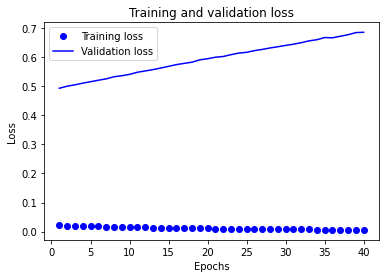

In [57]:
# 위의 결과로 나온 4개의 항목은 훈련과 검증 단계에서 모니터링 하는 지표
# 이를 그래프로 그려서 시각화 비교
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

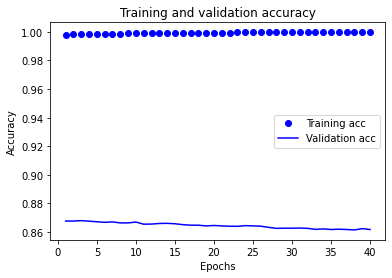

In [58]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

처음에는 그래프가 유사하게 증가하지만, 학습을 많이 시킬수록 변화가 없음   
그 이유는 **과대적합**때문

**과대적합**을 막기 위해 변화가 없는 epoch 근처에서 훈련을 멈출 수 있음   
그 방법은 callback을 사용하는 방법(추후 고급과정에서 나옴!!)